In [1]:
import copy
import os
import pandas as pd
import datetime
from sklearn.linear_model import LinearRegression
import math

def getClusterMap():
    poiList = []
    file = open('training_data/cluster_map/cluster_map', 'r')
    for line in file:
        curr = line.split()
        poiList.append(curr)
    return poiList

def getPOIData():
    poiList = []
    file = open('training_data/poi_data/poi_data', 'r')
    for line in file:
        curr = line.split()
        poiList.append(curr)
    return poiList

def getTimeSlot(dateT):
    t = []
    for time in dateT:
        date = time.date()
        hrs = time.hour
        mins = time.minute
    
        Tmins = hrs*60 + mins
        slot = (Tmins//10) + 1
    
        timeslot = date.strftime('%Y-%m-%d')  + '-'+ str(slot)
        t.append(timeslot)
    
    return t

def getWeekDay(dateT):
    t = []
    for time in dateT:
        t.append(int(time.weekday()))
    return t

def getOrderData(file):
    dir_path = "training_data/order_data"
    newDir = dir_path + '/' + file
    headers = ['order_id','driver_id','passenger_id','start_region_hash','dest_region_hash','Price','Time']
    dtypes = {'order_id':'str','driver_id':'str','passenger_id':'str','start_region_hash':'str','dest_region_hash':'str','Price':'float','Time':'str'}
    parse_dates = ['Time']
    df = pd.read_csv(newDir, sep='\t', header=None, names=headers, dtype=dtypes, parse_dates=parse_dates)
    return df

def getOrderList():
    orderfiles = os.listdir('training_data/order_data')
    orderList = []
    for file in orderfiles:
        df = getOrderData(file)
        df = setTimeSlots(df)
        orderList.append(df)
    return orderList

def getWeatherData(file):
    dir_path = "training_data/weather_data"
    newDir = dir_path + '/' + file
    headers = ['Time','Weather','temperature','PM2.5']
    dtypes = {'Time':'str','Weather':'str','temperature':'float','PM2.5':'float'}
    parse_dates = ['Time']
    df = pd.read_csv(newDir, sep='\t', header=None, names=headers, dtype=dtypes, parse_dates=parse_dates)
    return df

def getWeatherList():
    weatherfiles = os.listdir('training_data/weather_data')
    weatherList = []
    for file in weatherfiles:
        df = getWeatherData(file)
        df = setTimeSlots(df)
        weatherList.append(df)
    return weatherList

def getSlot(dateT):
    t = []
    for time in dateT:
        index = 0
        count = 0
        for i in range(len(time)):
            if time[i] == '-':
                count+=1
            if count == 3:
                index = i + 1
                break
        
        slot = time[index:]
        t.append(int(slot))
    return t

def setTimeSlots(df):
    df['Weekday'] = getWeekDay(df['Time'])
    df['Weekday'] = df['Weekday'].astype(int)
    df['Time'] = getTimeSlot(df['Time'])
    df['Slot'] = getSlot(df['Time'])
    df['Slot'] = df['Slot'].astype(int)
    return df

def getRegionID(cluster,regionHash):
    for tup in cluster:
        if tup[0] == regionHash:
            return tup[1]
    return regionHash

def setColumnRegionID(cluster,col):
    newcol = []
    for item in col:
        newcol.append(int(getRegionID(cluster,item)))
    
    return newcol

def groupGapCalc(group):
    countFound = 0
    total = 0
    for i in group.index:
        if pd.isna(group.loc[i, 'driver_id']):
            countFound += 1
        total += 1
    gap = total - countFound
    #group['Requested'] = gap
    group['Gap'] = countFound
    
    return group

def orderRideGap(df):
    grouped = df.groupby(['start_region_hash','Time']).apply(groupGapCalc).reset_index()
    return grouped

def getTestOrder(file):
    dir_path = "test_set/order_data"
    newDir = dir_path + '/' + file
    headers = ['order_id','passenger_id','start_region_hash','dest_region_hash','Time']
    dtypes = {'order_id':'str','passenger_id':'str','start_region_hash':'str','dest_region_hash':'str','Time':'str'}
    parse_dates = ['Time']
    df = pd.read_csv(newDir, sep=',', header=None, names=headers, dtype=dtypes, parse_dates=parse_dates)
    return df

def getTestOrderList():
    orderfiles = os.listdir('test_set/order_data')
    orderList = []
    for file in orderfiles:
        df = getTestOrder(file)
        df = setTimeSlots(df)
        orderList.append(df)
    return orderList

def getTestWeatherList():
    weatherfiles = os.listdir('test_set/weather_data')
    weatherList = []
    for file in weatherfiles:
        df = getTestWeather(file)
        df = setTimeSlots(df)
        weatherList.append(df)
    return weatherList

def getTestWeather(file):
    dir_path = "test_set/weather_data"
    newDir = dir_path + '/' + file
    headers = ['Time','Weather','temperature','PM2.5']
    dtypes = {'Time':'str','Weather':'int','temperature':'float','PM2.5':'float'}
    parse_dates = ['Time']
    df = pd.read_csv(newDir, sep='\t', header=None, names=headers, dtype=dtypes, parse_dates=parse_dates)
    return df

def changePOIRegion(poi, cluster):
    newcol = []
    i = 0
    for item in poi:
        poi[i][0] = int(getRegionID(cluster,item[0]))
        i += 1
    return poi

def getPOISum(item):
    poiSum = 0
    for i in range(1,len(item)):
        index = 0
        for j in range(len(item[i])):
            if item[i][j] == ':':
                index=j+1
                break
        amountStr = item[i][index:]
        poiSum += int(amountStr)
    return poiSum
def getPOIList(col, poi):
    poiList = []
    for i in range(len(col)):
        for place in poi:
            if col[i] == place[0]:
                poiList.append(getPOISum(place))
    return poiList

In [2]:
print("Reading Cluster Map...")
clusterMap = getClusterMap()
print("1 file read")

print("Reading Order Files and setting timeslots...")
orderList = getOrderList()
print(len(orderList), " files read")

print("Reading POI Data...")
poiData = getPOIData()
print("1 file read")

print("Reading Weather Data and setting timeslots...")
weatherList = getWeatherList()
print(len(weatherList), " files read")

print("#########################################")


Reading Cluster Map...
1 file read
Reading Order Files and setting timeslots...
21  files read
Reading POI Data...
1 file read
Reading Weather Data and setting timeslots...
21  files read
#########################################


In [3]:
merged1 = []
for i in range(len(orderList)):
    newmerge = pd.merge(orderList[i],weatherList[i], on='Time')
    newmerge=newmerge.drop_duplicates(subset = ['order_id'])
    newmerge = newmerge.reset_index(drop=True)
    merged1.append(newmerge)

for i in range(len(merged1)):
    merged1[i]['start_region_hash'] = setColumnRegionID(clusterMap,merged1[i]['start_region_hash'])
    merged1[i]['start_region_hash'] = merged1[i]['start_region_hash'].astype(int)

df = merged1[0]
print("#########################################")
df

#########################################


,order_id,driver_id,passenger_id,start_region_hash,dest_region_hash,Price,Time,Weekday_x,Slot_x,Weather,temperature,PM2.5,Weekday_y,Slot_y
0,97ebd0c6680f7c0535dbfdead6e51b4b,dd65fa250fca2833a3a8c16d2cf0457c,ed180d7daf639d936f1aeae4f7fb482f,23,3e12208dd0be281c92a6ab57d9a6fb32,24.0,2016-01-01-82,4,82,2,10.0,232.0,4,82
1,180470cf2f166e7251daaf8502fee301,0c9f1b5f77ace5984f6362ee23396fcb,905f4175dbd7df26fa8746cb599c84aa,51,d4ec2125aff74eded207d2d915ef682f,10.0,2016-01-01-82,4,82,2,10.0,232.0,4,82
2,2e43cb76acd916e71f473754244bbea4,NaN,9647cbbf7062110d25336aa026b1a389,14,d4ec2125aff74eded207d2d915ef682f,17.0,2016-01-01-82,4,82,2,10.0,232.0,4,82
3,6ee4f0b441191ba2b50fdbfdfcfcbb6a,NaN,9647cbbf7062110d25336aa026b1a389,14,d4ec2125aff74eded207d2d915ef682f,21.0,2016-01-01-82,4,82,2,10.0,232.0,4,82
4,d24dc99543aeaa38085fbd580aace9f2,476de29d4a7b8bcedea92bbf67a5d834,a139aa0ea89b162233afc02ed1fd00de,23,929ec6c160e6f52c20a4217c7978f681,67.0,2016-01-01-82,4,82,2,10.0,232.0,4,82
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
491672,81ae5abd09850afd9fa777f1950560c1,NaN,fb07f2e07ab2b10c3640c2bf181f638e,51,d4ec2125aff74eded207d2d915ef682f,5.0,2016-01-01-28,4,28,1,3.0,195.0,4,28
491673,c80275145bab6557d5ac8f8d84f9c452,a9559687e027a555b534ee052af32107,56018323b921dd2c5444f98fb45509de,7,82cc4851f9e4faa4e54309f8bb73fd7c,20.0,2016-01-01-28,4,28,1,3.0,195.0,4,28
491674,fcb9c1251255bafd32e265d6c8d6a47a,NaN,2592043ad8a3429d0e8e4a3b8fa9c5d9,23,d4ec2125aff74eded207d2d915ef682f,22.0,2016-01-01-28,4,28,1,3.0,195.0,4,28
491675,8b50ca307d8ae1fb9e9aaa91f79763f8,NaN,94c1a3300bf54052c28143a6927be65e,12,74c1c25f4b283fa74a5514307b0d0278,16.0,2016-01-01-28,4,28,1,3.0,195.0,4,28


In [4]:
gapList = []
for order in merged1:
    gapDF = orderRideGap(order)
    gapDF = gapDF.drop(columns = ['order_id','passenger_id','driver_id','Price','dest_region_hash','index', 'Weekday_y', 'Slot_y'], axis = 1)
    gapDF = gapDF.rename(columns = {'Weekday_x':'Weekday'})
    gapDF = gapDF.rename(columns = {'Slot_x':'Slot'})
    gapDF = gapDF.drop_duplicates(subset = ['start_region_hash','Time'])
    gapDF = gapDF.sort_values(by=['start_region_hash', 'Time'], ascending=[True, True])
    gapDF = gapDF.reset_index(drop=True)
    gapList.append(gapDF)

df =gapList[0]

print("#########################################")
df

#########################################


,start_region_hash,Time,Weekday,Slot,Weather,temperature,PM2.5,Gap
0,1,2016-01-01-1,4,1,1,4.0,177.0,9
1,1,2016-01-01-10,4,10,1,3.0,177.0,6
2,1,2016-01-01-100,4,100,2,12.0,168.0,5
3,1,2016-01-01-101,4,101,2,12.0,168.0,5
4,1,2016-01-01-102,4,102,2,11.0,154.0,3
...,...,...,...,...,...,...,...,...
8100,66,2016-01-01-95,4,95,2,12.0,168.0,1
8101,66,2016-01-01-96,4,96,2,13.0,168.0,0
8102,66,2016-01-01-97,4,97,2,12.0,168.0,0
8103,66,2016-01-01-98,4,98,2,12.0,168.0,0


In [5]:
poiData = changePOIRegion(poiData, clusterMap)
for frame in gapList:
    frame['POI'] = getPOIList(frame['start_region_hash'], poiData)

print('Done')
df = gapList[0]
df

Done


,start_region_hash,Time,Weekday,Slot,Weather,temperature,PM2.5,Gap,POI
0,1,2016-01-01-1,4,1,1,4.0,177.0,9,653376
1,1,2016-01-01-10,4,10,1,3.0,177.0,6,653376
2,1,2016-01-01-100,4,100,2,12.0,168.0,5,653376
3,1,2016-01-01-101,4,101,2,12.0,168.0,5,653376
4,1,2016-01-01-102,4,102,2,11.0,154.0,3,653376
...,...,...,...,...,...,...,...,...,...
8100,66,2016-01-01-95,4,95,2,12.0,168.0,1,138942
8101,66,2016-01-01-96,4,96,2,13.0,168.0,0,138942
8102,66,2016-01-01-97,4,97,2,12.0,168.0,0,138942
8103,66,2016-01-01-98,4,98,2,12.0,168.0,0,138942


In [6]:
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)
# print(gapList[0])
# pd.reset_option('display.max_rows')
# pd.reset_option('display.max_columns')

print("Reading Test Order Files and setting timeslots...")
testOrderList = getTestOrderList()
print(len(testOrderList), " files read")

print("Reading Test Weather Data and setting timeslots...")
testWeatherList = getTestWeatherList()
print(len(testWeatherList), " files read")

print("#########################################")
print("DONE")

Reading Test Order Files and setting timeslots...
5  files read
Reading Test Weather Data and setting timeslots...
5  files read
#########################################
DONE


In [7]:
testMerged = []
for i in range(len(testOrderList)):
    newmerge = pd.merge(testOrderList[i],testWeatherList[i], on='Time')
    newmerge = newmerge.drop_duplicates(subset = ['order_id'])
    newmerge = newmerge.reset_index(drop=True)
    newmerge = newmerge.drop(columns = ['order_id','passenger_id','dest_region_hash', 'Weekday_y', 'Slot_y'], axis = 1)
    newmerge = newmerge.rename(columns = {'Weekday_x':'Weekday'})
    newmerge = newmerge.rename(columns = {'Slot_x':'Slot'})
    newmerge = newmerge.sort_values(by=['start_region_hash', 'Time'], ascending=[True, True])
    testMerged.append(newmerge)
    
for i in range(len(testMerged)):
    testMerged[i]['start_region_hash'] = setColumnRegionID(clusterMap,testMerged[i]['start_region_hash'])
    testMerged[i]['start_region_hash'] = testMerged[i]['start_region_hash'].astype(int)

for frame in testMerged:
    frame['POI'] = getPOIList(frame['start_region_hash'], poiData)
    
df = testMerged[0]

print("#########################################")
print("DONE")
df

#########################################
DONE


,start_region_hash,Time,Weekday,Slot,Weather,temperature,PM2.5,POI
2337,50,2016-01-23-104,5,104,3,-2.0,43.0,187829
2338,50,2016-01-23-104,5,104,3,-2.0,43.0,1436921
2896,50,2016-01-23-104,5,104,3,-2.0,43.0,232068
3222,50,2016-01-23-104,5,104,3,-2.0,43.0,1711045
3789,50,2016-01-23-104,5,104,3,-2.0,43.0,495925
...,...,...,...,...,...,...,...,...
26196,32,2016-01-23-92,5,92,3,0.0,48.0,285105
26197,32,2016-01-23-92,5,92,3,0.0,48.0,475510
26438,32,2016-01-23-92,5,92,3,0.0,48.0,151641
27743,32,2016-01-23-92,5,92,3,0.0,48.0,1711045


In [31]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor

train = gapList[0]
curr = 0
for frame in gapList:
    curr += 1
    if curr < 2:
        continue
    train = pd.concat([train, frame], axis=0)

tempTrain = train.drop('Time', axis=1)
X = tempTrain.drop('Gap', axis=1)
y = train['Gap']

LinearModel = LinearRegression()
ErrModel = LinearRegression()
DTModel = DecisionTreeRegressor()
ErrDT = DecisionTreeRegressor()

LinearModel.fit(X, y)
DTModel.fit(X, y)

Err_X_train, Err_X_test, Err_y_train, Err_y_test = train_test_split(X, y, test_size=0.3)

ErrModel.fit(Err_X_train,Err_y_train)
ErrDT.fit(Err_X_train,Err_y_train)

LinearScore = ErrModel.score(Err_X_test, Err_y_test)
DTScore = ErrDT.score(Err_X_test, Err_y_test)

print("Accuracy for Linear Model is: ", LinearScore)
print("Accuracy for Decision Tree Model is: ", DTScore)

Err_Preds = ErrModel.predict(Err_X_test)

MAELinear = mean_absolute_error(Err_y_test, Err_Preds)

print("MAE for Linear Model is: ", MAELinear)

Err_Preds = ErrDT.predict(Err_X_test)

MAEDT = mean_absolute_error(Err_y_test, Err_Preds)

print("MAE for Decision Tree Model is: ", MAEDT)

dfTest = testMerged[0]
curr = 0
for frame in testMerged:
    curr += 1
    if curr < 2:
        continue
    dfTest = pd.concat([dfTest, frame], axis=0)

dfTest = dfTest.sort_values(by=['start_region_hash', 'Time'], ascending=[True, True])
dfTest = dfTest.reset_index(drop=True)
X_test = dfTest.drop('Time', axis=1)

y_pred = DTModel.predict(X_test)
dfTest['Pred_Gap'] = y_pred
dfTest['Pred_Gap'] = dfTest['Pred_Gap'].apply(math.floor)


Accuracy for Linear Model is:  0.10729186577886574
Accuracy for Decision Tree Model is:  0.828015919518307
MAE for Linear Model is:  10.810609149779083
MAE for Decision Tree Model is:  4.333904908547965


In [32]:
df = train
df

,start_region_hash,Time,Weekday,Slot,Weather,temperature,PM2.5,Gap,POI
0,1,2016-01-01-1,4,1,1,4.0,177.0,9,653376
1,1,2016-01-01-10,4,10,1,3.0,177.0,6,653376
2,1,2016-01-01-100,4,100,2,12.0,168.0,5,653376
3,1,2016-01-01-101,4,101,2,12.0,168.0,5,653376
4,1,2016-01-01-102,4,102,2,11.0,154.0,3,653376
...,...,...,...,...,...,...,...,...,...
2200,66,2016-01-21-48,3,48,4,1.0,50.0,0,138942
2201,66,2016-01-21-50,3,50,4,1.0,50.0,0,138942
2202,66,2016-01-21-54,3,54,4,1.0,49.0,0,138942
2203,66,2016-01-21-57,3,57,4,1.0,49.0,0,138942


In [33]:
df = dfTest
df

,start_region_hash,Time,Weekday,Slot,Weather,temperature,PM2.5,POI,Pred_Gap
0,1,2016-01-23-104,5,104,3,-2.0,43.0,727744,3
1,1,2016-01-23-104,5,104,3,-2.0,43.0,537591,3
2,1,2016-01-23-104,5,104,3,-2.0,43.0,1518402,87
3,1,2016-01-23-104,5,104,3,-2.0,43.0,1711045,87
4,1,2016-01-23-104,5,104,3,-2.0,43.0,3340833,31
...,...,...,...,...,...,...,...,...,...
354634,66,2016-01-31-93,6,93,2,4.0,109.0,1711045,5
354635,66,2016-01-31-93,6,93,2,4.0,109.0,475510,6
354636,66,2016-01-31-93,6,93,2,4.0,109.0,187829,1
354637,66,2016-01-31-93,6,93,2,4.0,109.0,1711045,5


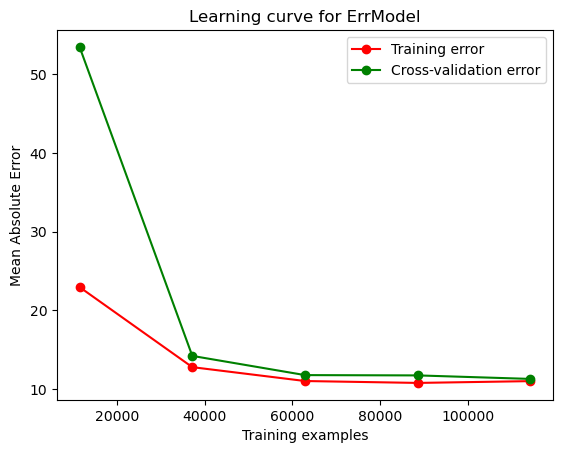

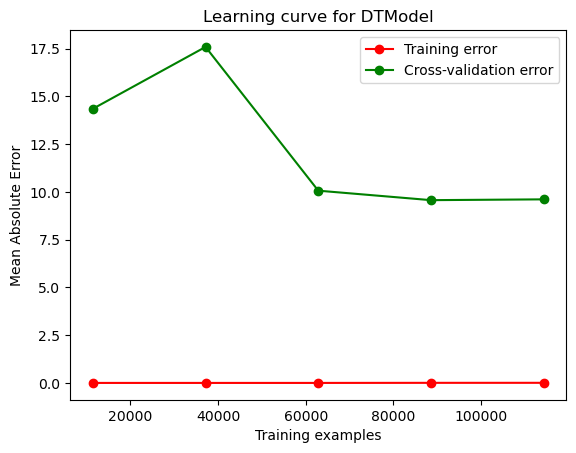

In [34]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import learning_curve

# Plot learning curve for ErrModel
train_sizes, train_scores, test_scores = learning_curve(ErrModel, X, y, cv=5, scoring='neg_mean_absolute_error')
train_scores_mean = -np.mean(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)
plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training error')
plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation error')
plt.title('Learning curve for ErrModel')
plt.xlabel('Training examples')
plt.ylabel('Mean Absolute Error')
plt.legend(loc='best')
plt.show()

# Plot learning curve for DTModel
train_sizes, train_scores, test_scores = learning_curve(DTModel, X, y, cv=5, scoring='neg_mean_absolute_error')
train_scores_mean = -np.mean(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)
plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training error')
plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation error')
plt.title('Learning curve for DTModel')
plt.xlabel('Training examples')
plt.ylabel('Mean Absolute Error')
plt.legend(loc='best')
plt.show()